## Lab: RNN with Forecasting

### Wind Turbine Power Prediction with RNN

This lab uses a Recurrent Neural Network to predict wind turbine power output.
* [Data link](https://www.kaggle.com/code/ahmedfathygwely/wind-turbine-dataset-machine-learning-rnn-times/input)

### Step 0: Load libraries & Data

In [29]:
# Step 0: Load libraries & Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import math

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load the data
df = pd.read_csv('T1.csv')

In [30]:
# Display basic information
# Display the first few rows of the dataframe
print(df.head())
print("--------------------------------")
# Display information about the dataframe
print(df.info())
print("--------------------------------")
# Display summary statistics of the dataframe
print(df.describe())
print("--------------------------------")
# Check for missing values
print(df.isnull().sum())
print("--------------------------------")
# Check for duplicates
print(f"Number of duplicates: {df.duplicated().sum()}")

          Date/Time  LV ActivePower (kW)  Wind Speed (m/s)  \
0  01 01 2018 00:00           380.047791          5.311336   
1  01 01 2018 00:10           453.769196          5.672167   
2  01 01 2018 00:20           306.376587          5.216037   
3  01 01 2018 00:30           419.645905          5.659674   
4  01 01 2018 00:40           380.650696          5.577941   

   Theoretical_Power_Curve (KWh)  Wind Direction (°)  
0                     416.328908          259.994904  
1                     519.917511          268.641113  
2                     390.900016          272.564789  
3                     516.127569          271.258087  
4                     491.702972          265.674286  
--------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Date/Time                      

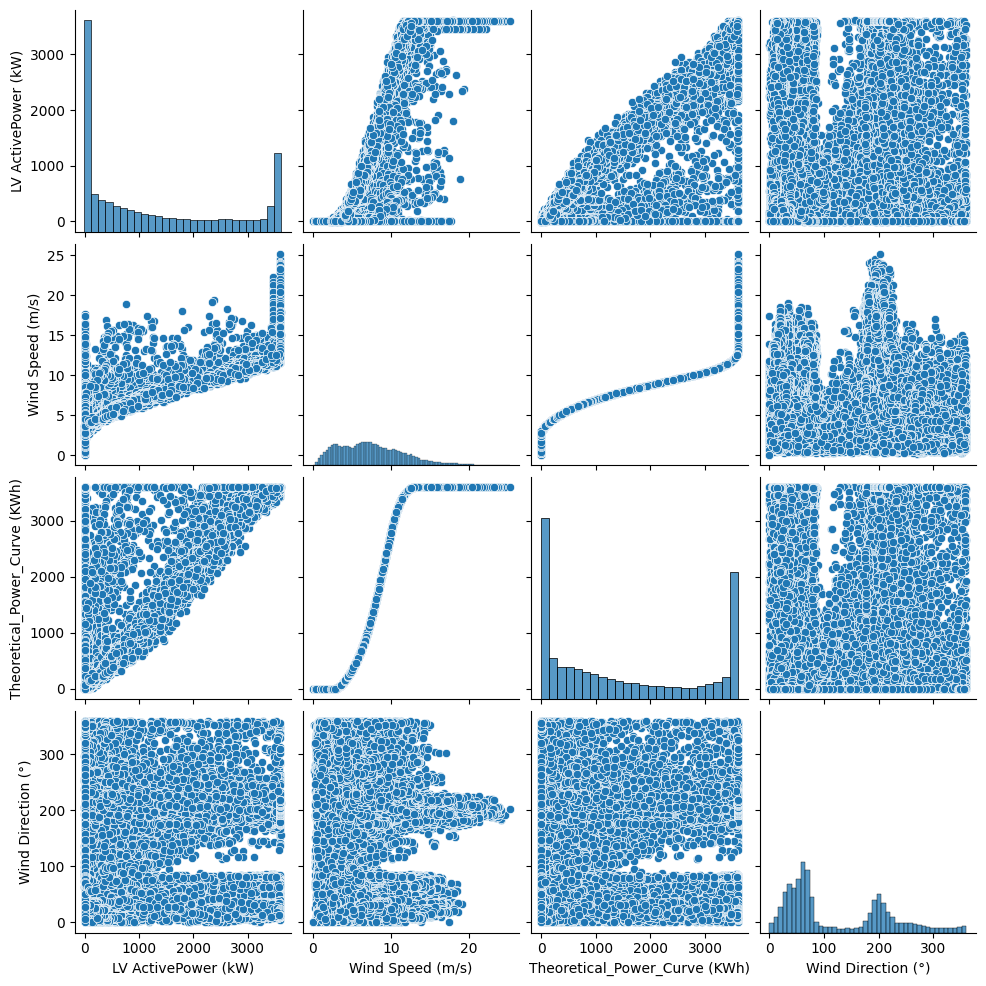

In [32]:
# Use seaborn to plot the relationships between the variables
sns.pairplot(df)
plt.show()


### Step 1: Prepare the data

In [33]:
# Step 1: Prepare the data
df['Date/Time'] = pd.to_datetime(df['Date/Time'], format='mixed')
df.set_index('Date/Time', inplace=True)

In [34]:
df_rel = df.copy().drop('Wind Direction (°)', axis=1)
data = df_rel.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
scaled_data.shape

(50530, 3)

### Step 2: Create sequences

In [39]:
# Step 2: Create sequences
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i,0])
        y.append(data[i,0])

    X = np.array(X)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    y = np.array(y)
    return X, y

### Step 3: Split the data

In [41]:
# Step 3: Split the data
seq_size = 24
X, y = create_sequences(scaled_data, seq_size)
split = int(0.8 * len(X))
X_train = X[:split]
X_test = X[split:]
y_train = y[:split]
y_test = y[split:]

# Print the shapes of the training and test sets
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (40404, 24, 1)
y_train shape: (40404,)
X_test shape: (10102, 24, 1)
y_test shape: (10102,)


### Step 4: Build the RNN Model

In [43]:
# Step 4: Build the RNN Model

model = Sequential(
    [
        LSTM(50, activation='tanh', input_shape=(seq_size, 1), return_sequences=True),
        Dropout(0.2),
        LSTM(50, activation='tanh'),
        Dropout(0.2),
        Dense(1)
    ]
)
model.compile(optimizer='adam', loss='mse')

#print model summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 24, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

### Step 5: Train the model

In [45]:
# Step 5: Train the model
# Set up callbacks with early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

callbacks = [early_stopping, model_checkpoint]

# Train the model
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), callbacks=callbacks)


Epoch 1/30
1256/1263 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0053

1263/1263 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0054 - val_loss: 0.0044
Epoch 2/30
1255/1263 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0053

1263/1263 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0054 - val_loss: 0.0043
Epoch 3/30
1257/1263 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0054

1263/1263 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0054 - val_loss: 0.0041
Epoch 4/30
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0054 - val_loss: 0.0045
Epoch 5/30
1262/1263 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0053

1263/1263 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0054 - val_loss: 0.0040
Epoch 6/30
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0053 - val_loss: 0.0042
Epoch 7/30
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0053 - val_loss: 0.0042
Epoch 8/30
1257/1263 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0053

1263/1263 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0053 - val_loss: 0.0040
Epoch 9/30
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0053 - val_loss: 0.0042
Epoch 10/30
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0053 - val_loss: 0.0043
Epoch 11/30
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0054 - val_loss: 0.0043
Epoch 12/30
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0053 - val_loss: 0.0044
Epoch 13/30
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0053 - val_loss: 0.0043
Epoch 14/30
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0053 - val_loss: 0.0043
Epoch 15/30
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0053 - val_loss: 0.0043
Epoch 16/30
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0053 - val_loss: 0.0045
Epoch 17/30
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0053 - val_loss: 0.0043
Epoch 18/30
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0052 - val_loss: 0.0042


### Step 6: Evaluate on the test data and visualize the results

In [64]:
# Step 6: Evaluate and visualize
y_pred = model.predict(X_test)
y_pred_new = y_pred.reshape(-1)

316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
(10102,)
(10102,)
Test MSE: 0.004018147318038334


In [ ]:
#add empty columns to y_pred and y_test to match expected (10102,3) shape
y_pred_to_inv = np.zeros((10102,3))
#set the first column to y_pred
y_pred_to_inv[:,0] = y_pred_new
y_test_to_inv = np.zeros((10102,3))
#set the first column to y_test
y_test_to_inv[:,0] = y_test

y_pred_inv = scaler.inverse_transform(y_pred_to_inv) 
y_test_inv = scaler.inverse_transform(y_test_to_inv)

#extract the first column from y_pred_inv and y_test_inv
y_pred_inv = y_pred_inv[:,0]
y_test_inv = y_test_inv[:,0]


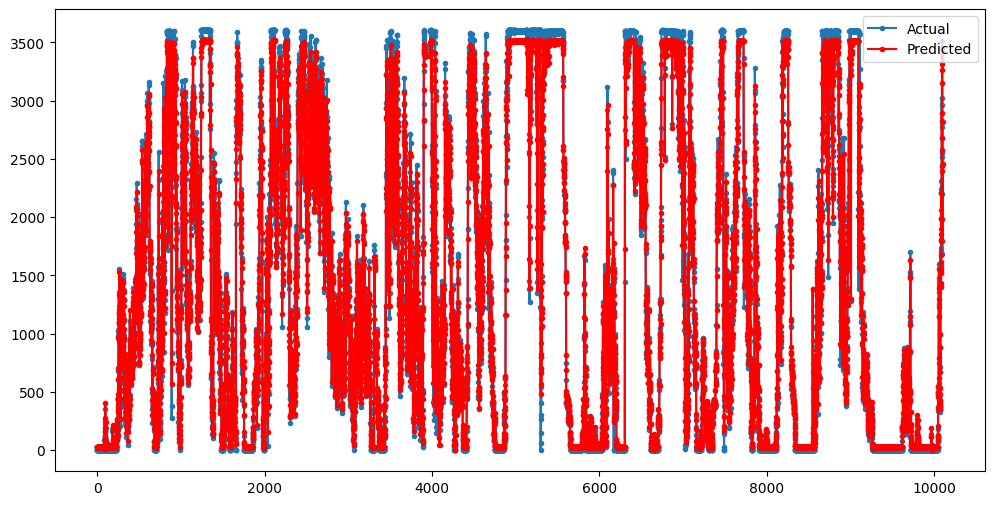

In [72]:
plt.figure(figsize=(12,6))
plt.plot(y_test_inv.flatten(), marker='.', label="Actual")
plt.plot(y_pred_inv.flatten(), 'r', marker='.', label="Predicted")
plt.legend()
plt.show()

In [73]:
y_pred_for_mse = y_pred_inv.reshape(-1)
y_test_for_mse = y_test_inv.reshape(-1)
print(y_pred_for_mse.shape)
print(y_test_for_mse.shape)
mse = ((y_pred_for_mse - y_test_for_mse)**2).mean(axis=0)
print(f'Test MSE: {mse}')

(10102,)
(10102,)
Test MSE: 52690.45074095227
